##**Neural Network: Can a neural network predict Poverty Headcount Ratios based on a combination of Social and Economic Indicators?**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files
import warnings

In [ ]:
import sklearn

class KerasRegressorWrapper:
    def __init__(self, build_fn, **kwargs):
        self.build_fn = build_fn
        self.kwargs = kwargs
        self.model = None

    def fit(self, X, y, **kwargs):
        self.model = self.build_fn()
        self.model.fit(X, y, **{**self.kwargs, **kwargs})
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

TensorFlow version: 2.18.0
NumPy version: 2.0.2
Pandas version: 2.2.2
Scikit-learn version: 1.6.1


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def handle_missing_values(X, strategy='mean'):
    """
    Handle missing values in a numpy array

    Parameters:
    X (numpy.ndarray): The input array with potential NaN values
    strategy (str): Strategy to fill missing values ('mean', 'median', 'zero')

    Returns:
    numpy.ndarray: Array with NaN values filled
    """
    if not np.isnan(X).any():
        return X

    X_copy = X.copy()

    for col in range(X.shape[1]):
        col_data = X[:, col]
        mask = np.isnan(col_data)
        if mask.any():
            if strategy == 'mean':
                fill_value = np.nanmean(col_data)
            elif strategy == 'median':
                fill_value = np.nanmedian(col_data)
            elif strategy == 'zero':
                fill_value = 0
            else:
                raise ValueError(f"Unknown strategy: {strategy}")

            X_copy[mask, col] = fill_value

    return X_copy

###**Data Shape and Summary Stats**

In [ ]:
uploaded = files.upload()

filename = list(uploaded.keys())[0]
data = pd.read_csv(filename)

Saving ResearchQ3_Extraction.csv to ResearchQ3_Extraction.csv


In [ ]:
print("Dataset shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())
print("\nData types:")
print(data.dtypes)
print("\nMissing values:")
print(data.isnull().sum())

Dataset shape: (273, 23)

First 5 rows:
  country_code country_name                           region  year  \
0          ALB      Albania          Europe and Central Asia  2019   
1          ALB      Albania          Europe and Central Asia  2020   
2          ARG    Argentina  Latin America and the Caribbean  2019   
3          ARG    Argentina  Latin America and the Caribbean  2020   
4          ARG    Argentina  Latin America and the Caribbean  2021   

   Poverty_HeadcountRatio_NationalPovertyLines_Percent  \
0                                               21.8     
1                                               22.0     
2                                               35.5     
3                                               42.0     
4                                               37.3     

   Multidim_PovertyHeadcountRatio_WorldBank  LifeExpectancy_Total  \
0                                       NaN                79.282   
1                                       NaN         

###**Identify Target Variable and Features**

In [ ]:
target_var = 'Poverty_HeadcountRatio_NationalPovertyLines_Percent'
features = ['LifeExpectancy_Total',
            'Unemployment_Total_Percent',
            'Water_BasicDrinkingServices_PercentofPop',
            'ElectricityAccess_PercentofPopulation',
            'GDP_Growth_Percent',
            'Trade_PercentGDP']

In [ ]:
complete_rows = data.dropna(subset=[target_var] + features)

print(f"Complete rows: {len(complete_rows)} out of {len(data)} ({len(complete_rows)/len(data)*100:.2f}%)")

Complete rows: 189 out of 189 (100.00%)


###**Model Preparation**

In [ ]:
if len(complete_rows) < 50:
    print("Not enough complete rows. Using imputation for missing values...")
    # Mean Imputation
    for column in data.select_dtypes(include=['float64', 'int64']).columns:
        if data[column].isnull().sum() > 0:
            mean_val = data[column].mean()
            data[column].fillna(mean_val, inplace=True)
            print(f"Imputed {column} with mean value: {mean_val:.2f}")
else:
    print("Using only complete rows for analysis...")
    data = complete_rows

print("\nMissing values after handling:")
print(data[[target_var] + features].isnull().sum())

Using only complete rows for analysis...

Missing values after handling:
Poverty_HeadcountRatio_NationalPovertyLines_Percent    0
LifeExpectancy_Total                                   0
Unemployment_Total_Percent                             0
Water_BasicDrinkingServices_PercentofPop               0
ElectricityAccess_PercentofPopulation                  0
GDP_Growth_Percent                                     0
Trade_PercentGDP                                       0
dtype: int64


In [ ]:
X = data[features]
y = data[target_var]

# Split data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15/0.85, random_state=42)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 131 samples
Validation set: 29 samples
Test set: 29 samples


In [ ]:
# Check for NaN values before standardization
print("\nChecking for NaN values in sets before standardization:")
print(f"X_train NaN count: {np.isnan(X_train).sum()}")
print(f"X_val NaN count: {np.isnan(X_val).sum()}")
print(f"X_test NaN count: {np.isnan(X_test).sum()}")


Checking for NaN values in sets before standardization:
X_train NaN count: LifeExpectancy_Total                        0
Unemployment_Total_Percent                  0
Water_BasicDrinkingServices_PercentofPop    0
ElectricityAccess_PercentofPopulation       0
GDP_Growth_Percent                          0
Trade_PercentGDP                            0
dtype: int64
X_val NaN count: LifeExpectancy_Total                        0
Unemployment_Total_Percent                  0
Water_BasicDrinkingServices_PercentofPop    0
ElectricityAccess_PercentofPopulation       0
GDP_Growth_Percent                          0
Trade_PercentGDP                            0
dtype: int64
X_test NaN count: LifeExpectancy_Total                        0
Unemployment_Total_Percent                  0
Water_BasicDrinkingServices_PercentofPop    0
ElectricityAccess_PercentofPopulation       0
GDP_Growth_Percent                          0
Trade_PercentGDP                            0
dtype: int64


In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print("\nChecking for NaN values after standardization:")
print(f"X_train_scaled NaN count: {np.isnan(X_train_scaled).sum()}")
print(f"X_val_scaled NaN count: {np.isnan(X_val_scaled).sum()}")
print(f"X_test_scaled NaN count: {np.isnan(X_test_scaled).sum()}")
print(f"y_train NaN count: {np.isnan(y_train.values).sum()}")
print(f"y_val NaN count: {np.isnan(y_val.values).sum()}")
print(f"y_test NaN count: {np.isnan(y_test.values).sum()}")


Checking for NaN values after standardization:
X_train_scaled NaN count: 0
X_val_scaled NaN count: 0
X_test_scaled NaN count: 0
y_train NaN count: 0
y_val NaN count: 0
y_test NaN count: 0


###**Correlation Matrix**

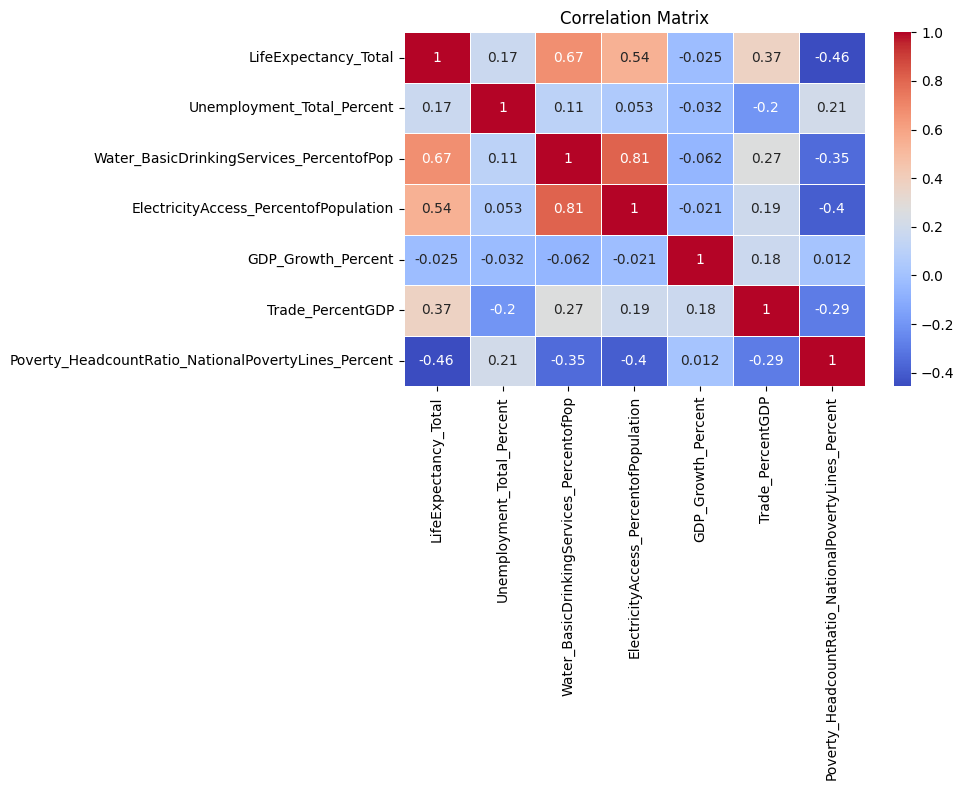

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = data[features + [target_var]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

###**Data Distribution**

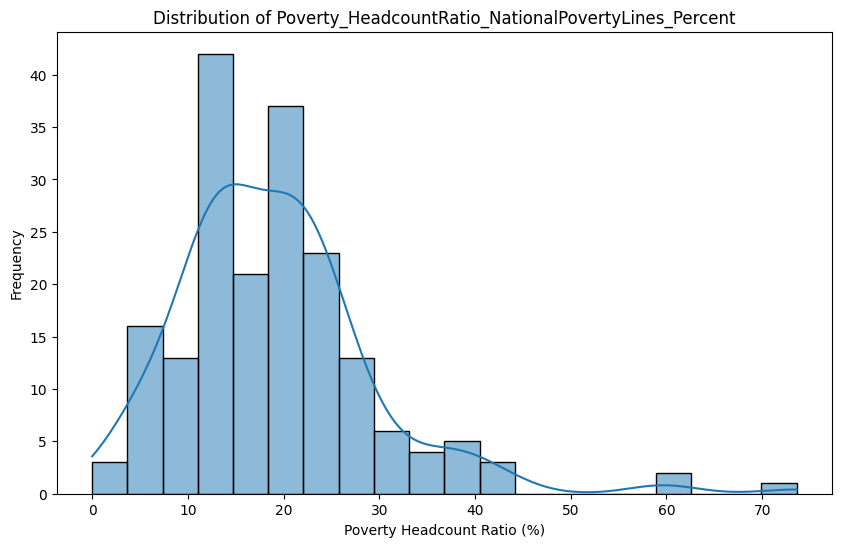

In [ ]:
# Distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(data[target_var], kde=True)
plt.title(f'Distribution of {target_var}')
plt.xlabel('Poverty Headcount Ratio (%)')
plt.ylabel('Frequency')
plt.show()

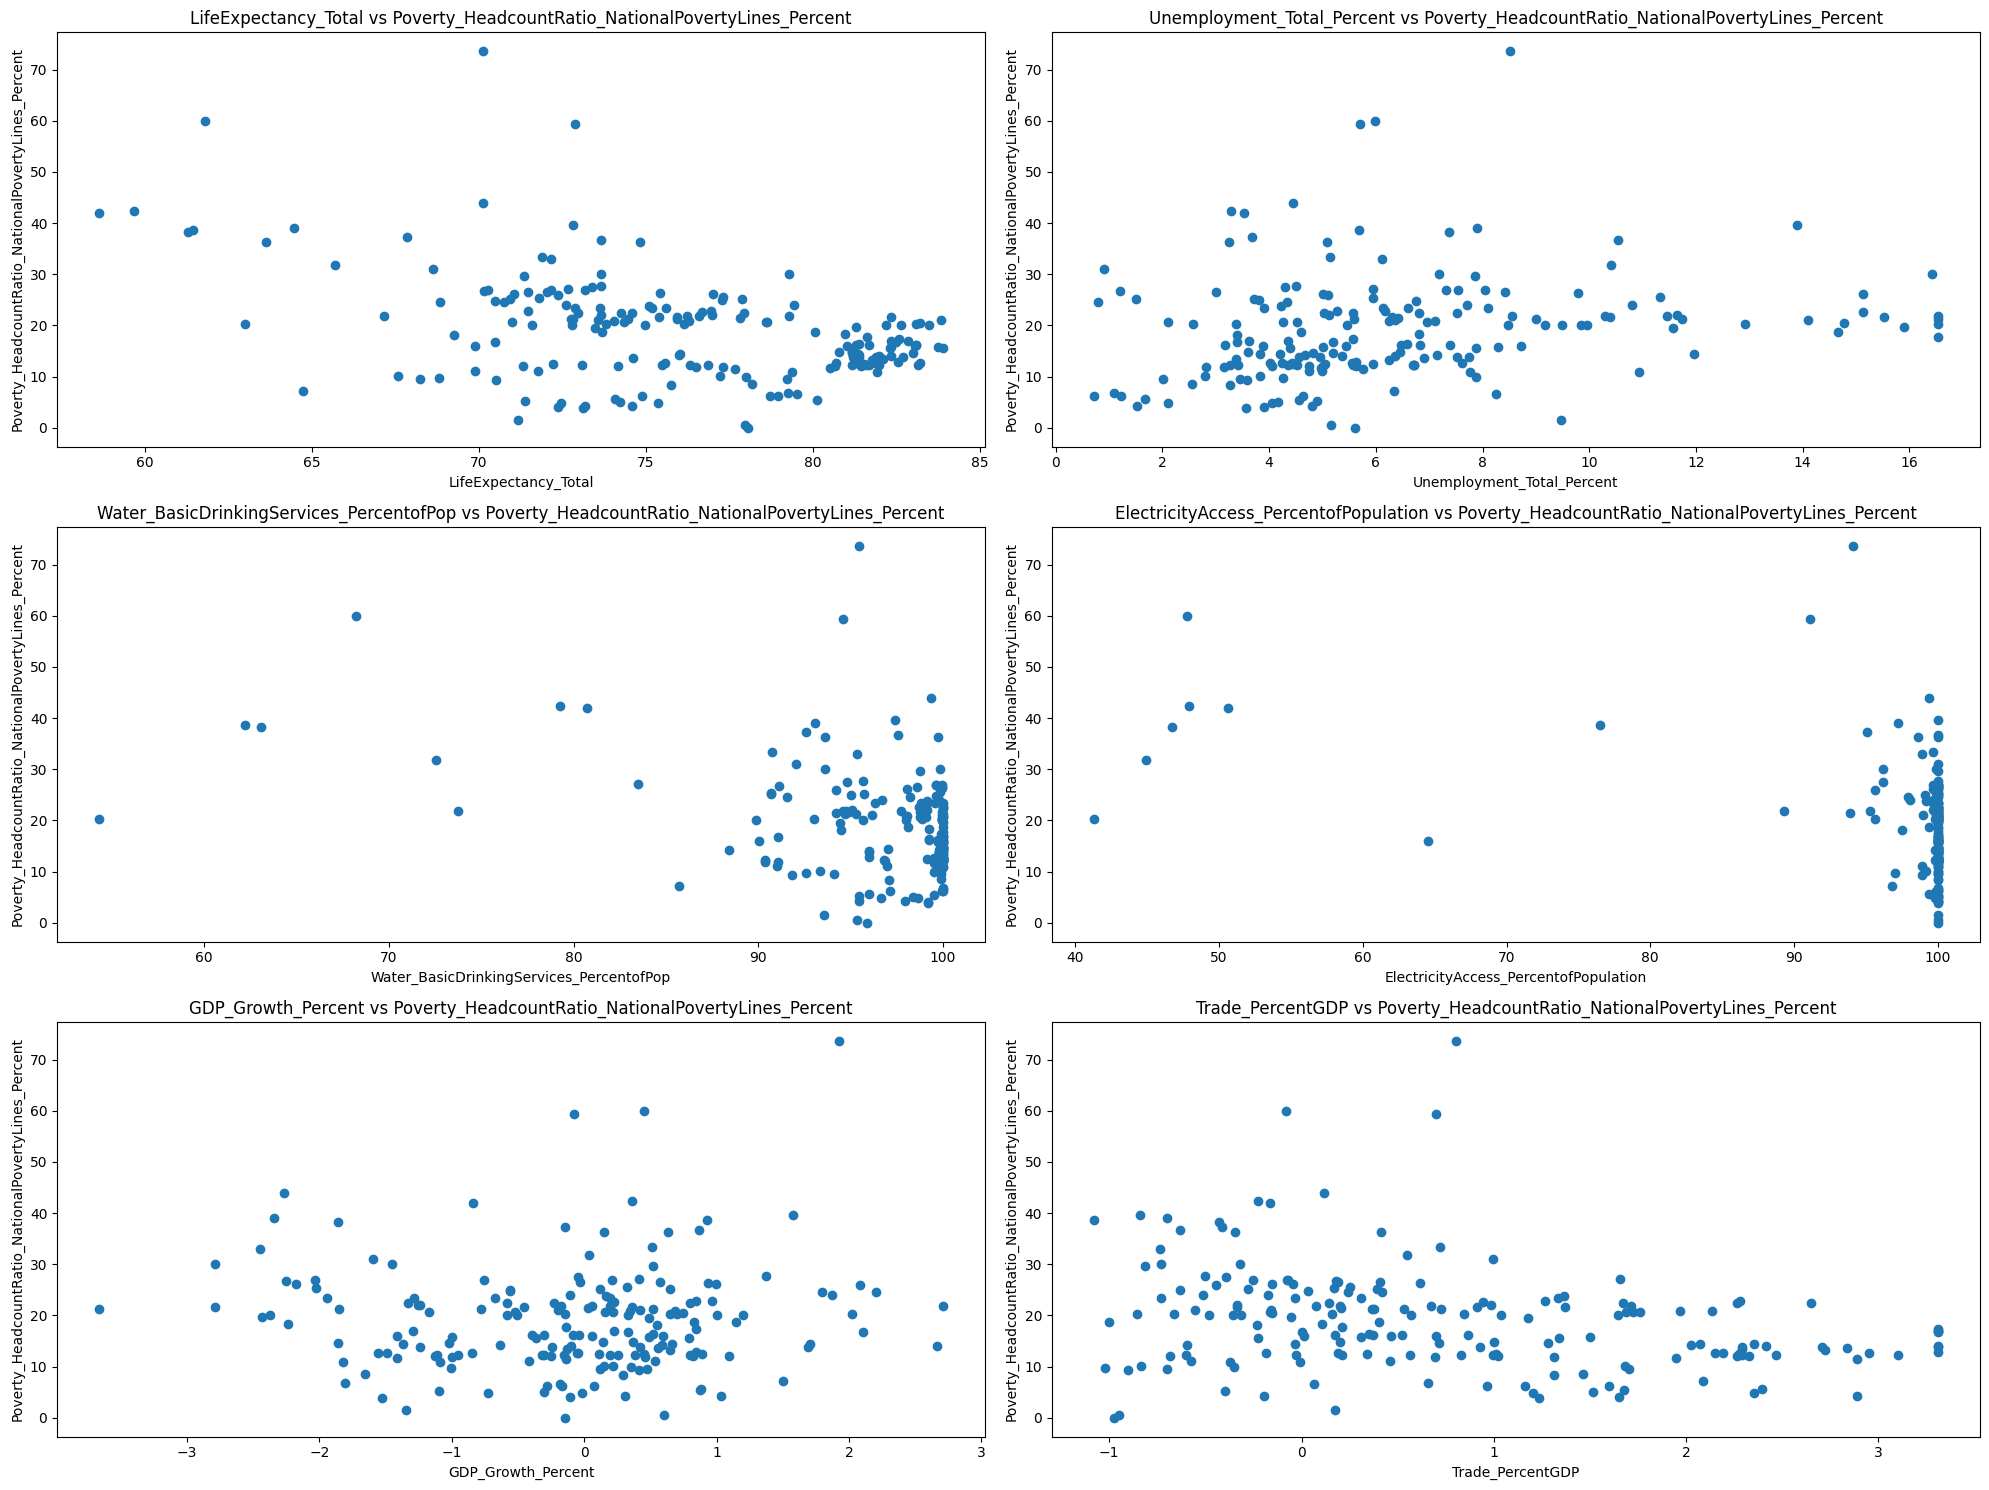

In [ ]:
# Pairplot of features vs target
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)
    plt.scatter(data[feature], data[target_var])
    plt.title(f'{feature} vs {target_var}')
    plt.xlabel(feature)
    plt.ylabel(target_var)
plt.tight_layout()
plt.show()

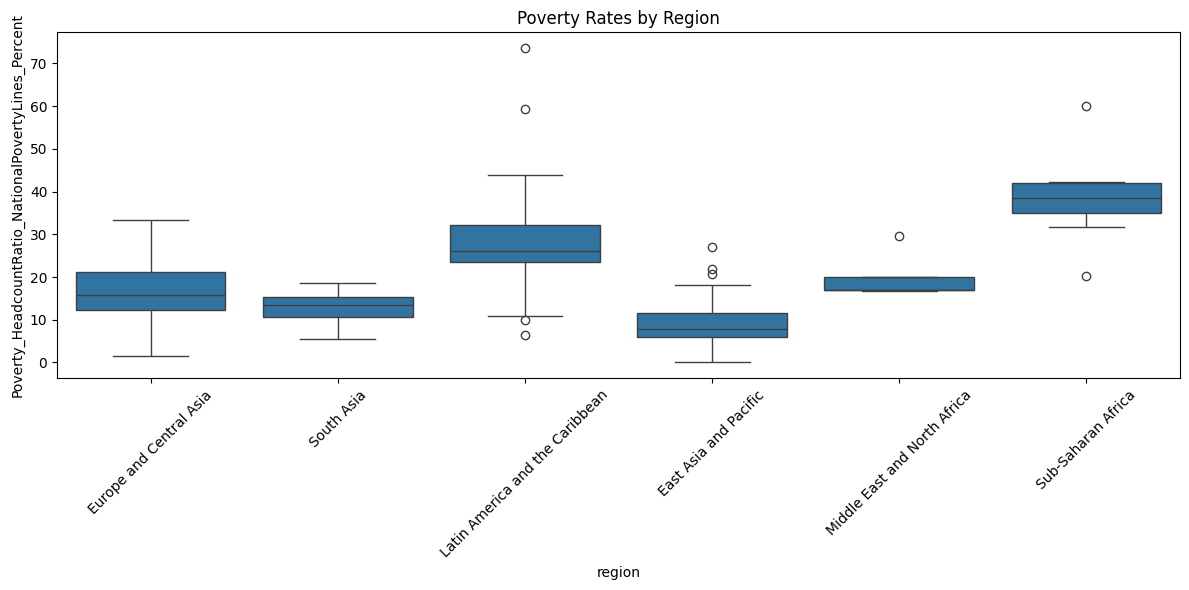

In [ ]:
# Regional distribution of poverty rates
plt.figure(figsize=(12, 6))
sns.boxplot(x='region', y=target_var, data=data)
plt.title('Poverty Rates by Region')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###**Linear Regression to Compare Neural Network**

In [ ]:
# Baseline Linear Regression model for comparison
try:
    baseline_model = LinearRegression()
    baseline_model.fit(X_train_scaled, y_train)

    # Evaluate baseline model
    y_pred_baseline = baseline_model.predict(X_test_scaled)
    baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
    baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
    baseline_r2 = r2_score(y_test, y_pred_baseline)

    print("\nBaseline Linear Regression Model Performance:")
    print(f"MAE: {baseline_mae:.2f}")
    print(f"RMSE: {baseline_rmse:.2f}")
    print(f"R²: {baseline_r2:.2f}")
except Exception as e:
    print(f"\nError in Linear Regression model: {e}")
    print("Proceeding with neural network without baseline comparison.")
    baseline_mae, baseline_rmse, baseline_r2 = None, None, None


Baseline Linear Regression Model Performance:
MAE: 7.67
RMSE: 11.20
R²: 0.36


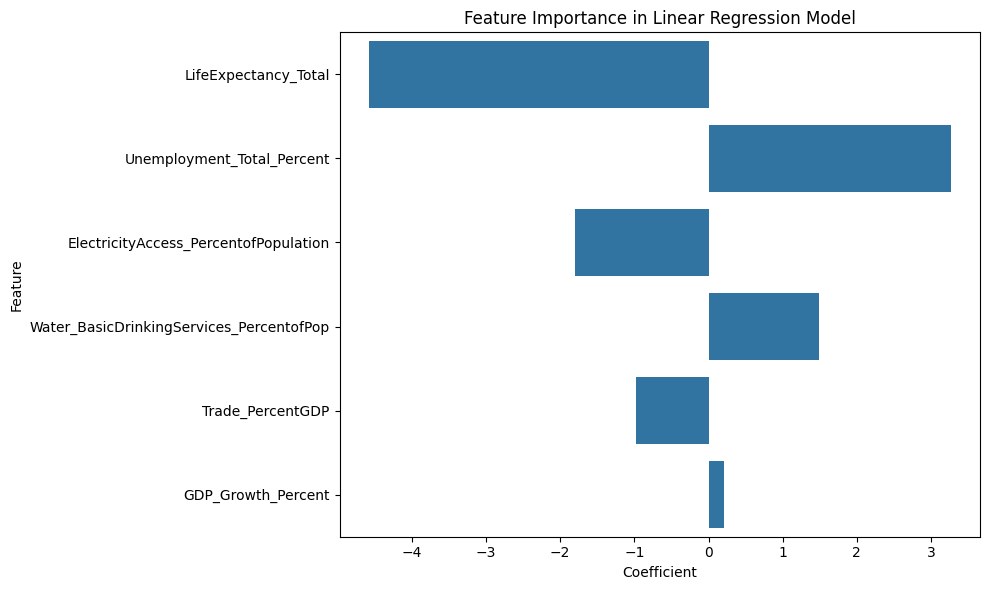

In [ ]:
# Feature importance in linear model
plt.figure(figsize=(10, 6))
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': baseline_model.coef_
})
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Feature Importance in Linear Regression Model')
plt.tight_layout()
plt.show()

In [ ]:
def create_model(input_dim):
    model = Sequential([
        Dense(12, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

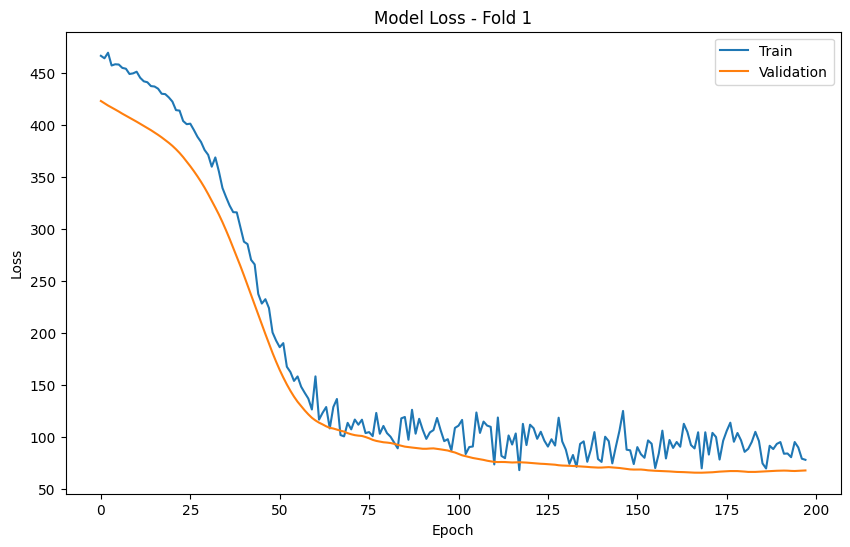

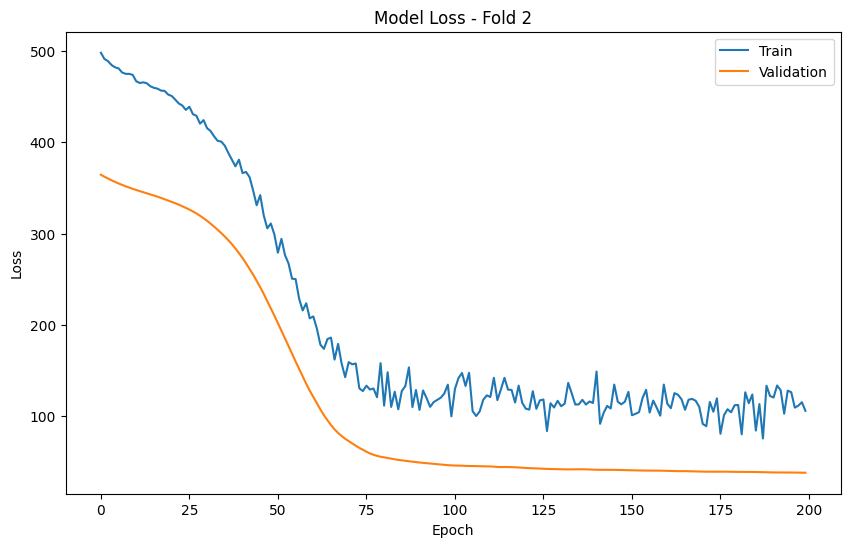

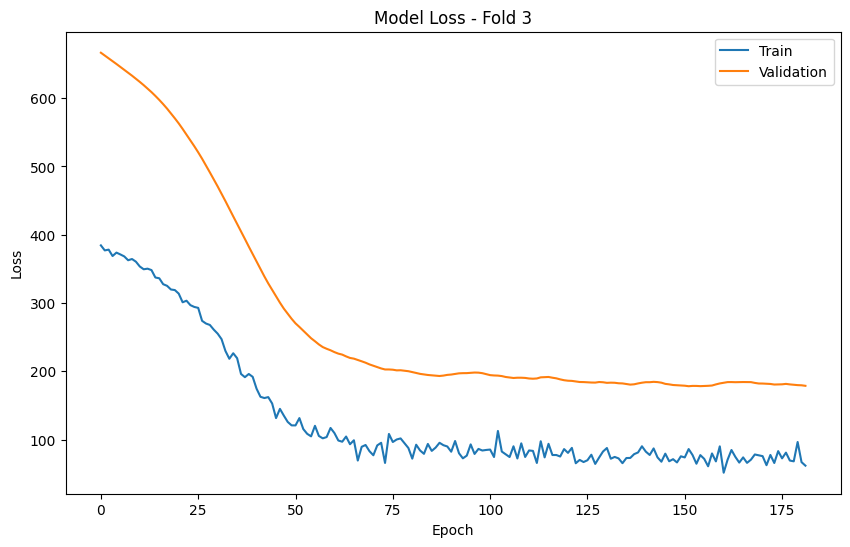

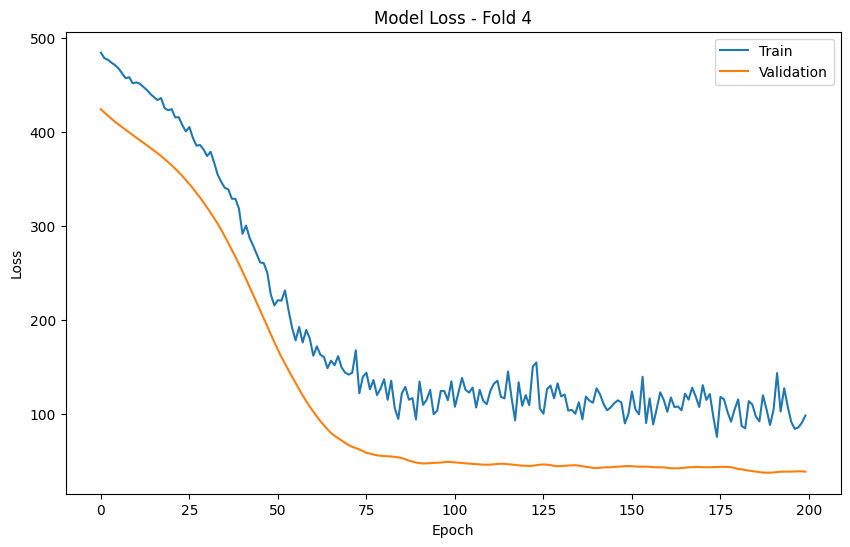

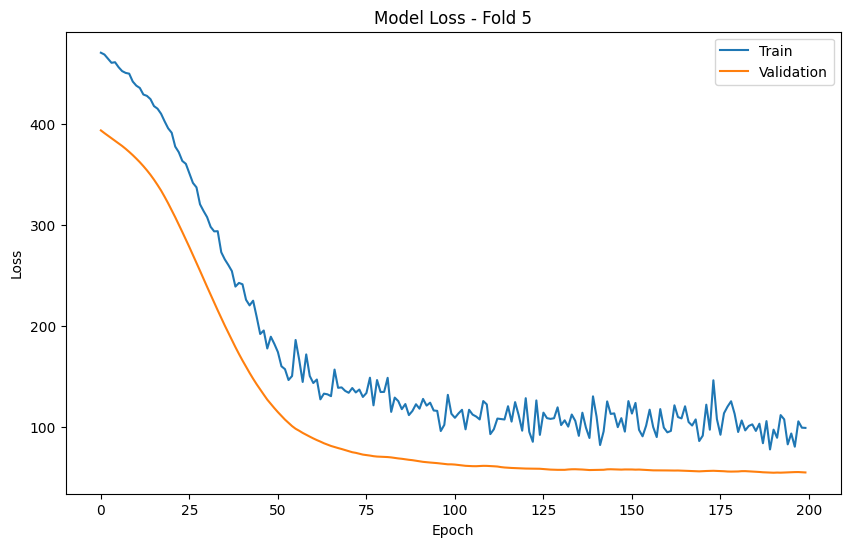


Cross-Validation Results (MAE):
Fold 1: 6.70
Fold 2: 4.95
Fold 3: 7.73
Fold 4: 4.40
Fold 5: 5.84
Average MAE: 5.92


In [ ]:
# K-fold cross-validation
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)
cv_scores = []

try:
    for train_idx, val_idx in kfold.split(X_train_scaled):
        X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Additional check for NaN values in fold
        if np.isnan(X_fold_train).any() or np.isnan(X_fold_val).any():
            print("Warning: NaN values found in fold. Filling with column means...")
            # Handle NaN values in training fold
            if np.isnan(X_fold_train).any():
                col_means = np.nanmean(X_fold_train, axis=0)
                nan_indices = np.where(np.isnan(X_fold_train))
                X_fold_train[nan_indices] = np.take(col_means, nan_indices[1])

            # Handle NaN values in validation fold
            if np.isnan(X_fold_val).any():
                col_means = np.nanmean(X_fold_val, axis=0)
                nan_indices = np.where(np.isnan(X_fold_val))
                X_fold_val[nan_indices] = np.take(col_means, nan_indices[1])

        model = create_model(X_train_scaled.shape[1])

        history = model.fit(
            X_fold_train, y_fold_train,
            epochs=200,
            batch_size=16,
            validation_data=(X_fold_val, y_fold_val),
            callbacks=[early_stopping],
            verbose=0
        )

        val_mae = model.evaluate(X_fold_val, y_fold_val, verbose=0)[1]
        cv_scores.append(val_mae)

        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'Model Loss - Fold {len(cv_scores)}')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

    print(f"\nCross-Validation Results (MAE):")
    for i, score in enumerate(cv_scores):
        print(f"Fold {i+1}: {score:.2f}")
    print(f"Average MAE: {np.mean(cv_scores):.2f}")
except Exception as e:
    print(f"Error in cross-validation: {e}")

###**Final Neural Network Model**

In [ ]:
final_model = create_model(X_train_scaled.shape[1])

history = final_model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate final model performance
y_pred = final_model.predict(X_test_scaled)
nn_mae = mean_absolute_error(y_test, y_pred)
nn_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
nn_r2 = r2_score(y_test, y_pred)

print("\nNeural Network Model Performance:")
print(f"MAE: {nn_mae:.2f}")
print(f"RMSE: {nn_rmse:.2f}")
print(f"R²: {nn_r2:.2f}")

# Compare neural network with baseline model
print("\nModel Comparison:")
print(f"{'Metric':<10} {'Linear Regression':<20} {'Neural Network':<20}")

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 397.6177 - mae: 17.7153 - val_loss: 422.1869 - val_mae: 19.0208
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 392.8207 - mae: 17.5520 - val_loss: 415.7878 - val_mae: 18.8748
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 391.8987 - mae: 17.4751 - val_loss: 409.2237 - val_mae: 18.7237
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 383.9715 - mae: 17.3381 - val_loss: 402.2867 - val_mae: 18.5635
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 377.8467 - mae: 17.1349 - val_loss: 395.1113 - val_mae: 18.3959
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 374.3698 - mae: 16.9957 - val_loss: 387.8486 - val_mae: 18.2229
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 369.3200 - mae: 16.9189 - val_loss: 380.5669 - val_mae: 18.0460
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 357.0611 - mae: 16.5299 - val_loss: 372.6625 - val_mae: 17.8637
Epoch 9/200
9/9 ━━━━━━━━

###**Model Performance Comparison**

In [ ]:
# Compare neural network with baseline model
print("\nModel Comparison:")
print(f"{'Metric':<10} {'Linear Regression':<20} {'Neural Network':<20}")

if baseline_mae is not None and baseline_rmse is not None and baseline_r2 is not None:
    print(f"{'MAE':<10} {baseline_mae:<20.2f} {nn_mae:<20.2f}")
    print(f"{'RMSE':<10} {baseline_rmse:<20.2f} {nn_rmse:<20.2f}")
    print(f"{'R²':<10} {baseline_r2:<20.2f} {nn_r2:<20.2f}")

    # Calculate improvement percentages
    mae_improvement = ((baseline_mae - nn_mae) / baseline_mae) * 100
    rmse_improvement = ((baseline_rmse - nn_rmse) / baseline_rmse) * 100
    r2_improvement = ((nn_r2 - baseline_r2) / abs(baseline_r2)) * 100 if baseline_r2 != 0 else float('inf')

    print("\nNeural Network Improvement Over Linear Regression:")
    print(f"MAE Improvement: {mae_improvement:.2f}%")
    print(f"RMSE Improvement: {rmse_improvement:.2f}%")
    print(f"R² Improvement: {r2_improvement:.2f}%")
else:
    print(f"{'MAE':<10} {'N/A':<20} {nn_mae:<20.2f}")
    print(f"{'RMSE':<10} {'N/A':<20} {nn_rmse:<20.2f}")
    print(f"{'R²':<10} {'N/A':<20} {nn_r2:<20.2f}")
    print("\nNote: Baseline model results not available for comparison")


Model Comparison:
Metric     Linear Regression    Neural Network      
MAE        7.67                 8.67                
RMSE       11.20                12.86               
R²         0.36                 0.16                

Neural Network Improvement Over Linear Regression:
MAE Improvement: -13.04%
RMSE Improvement: -14.78%
R² Improvement: -56.63%


###**Training History**

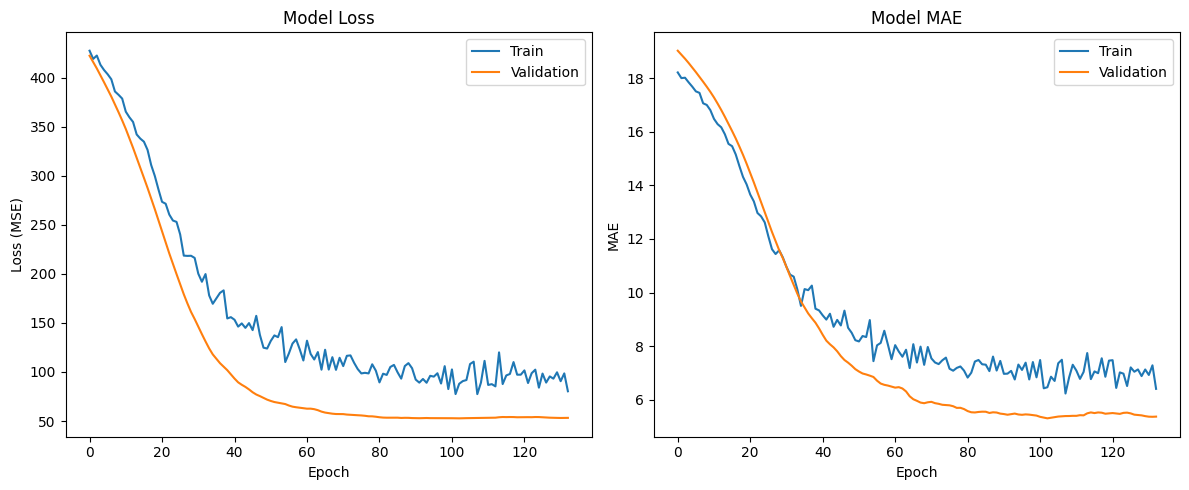

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

###**Neural Network Prediction Visualization**

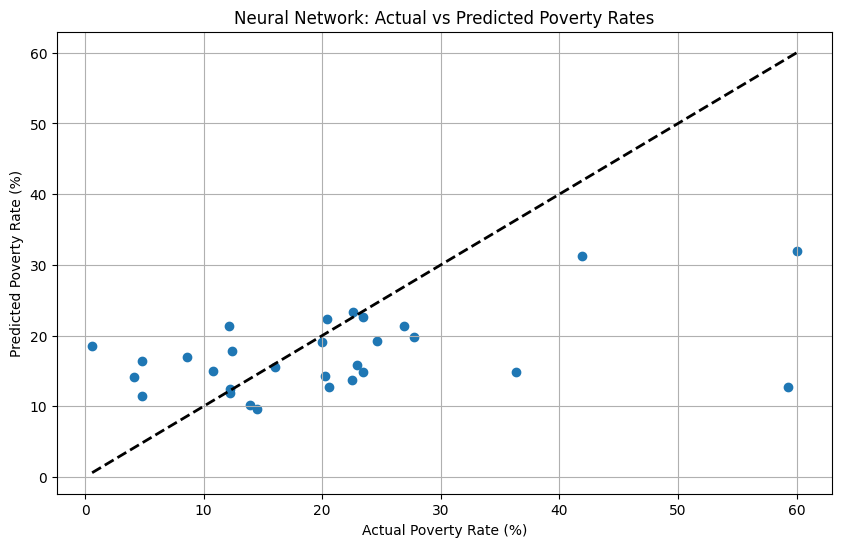

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Poverty Rate (%)')
plt.ylabel('Predicted Poverty Rate (%)')
plt.title('Neural Network: Actual vs Predicted Poverty Rates')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

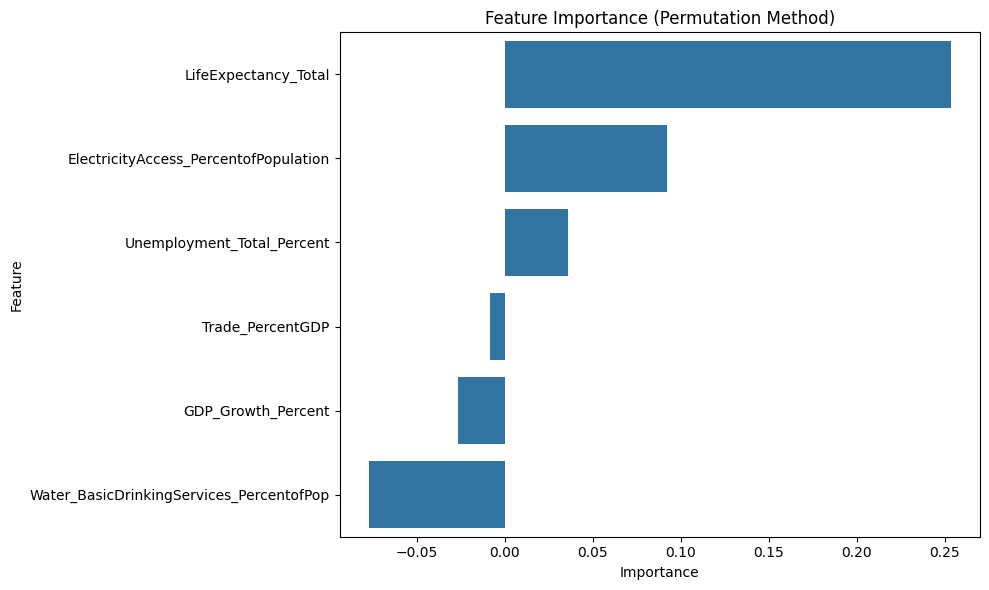

In [ ]:
from sklearn.inspection import permutation_importance

def create_model_wrapper():
    return create_model(X_train_scaled.shape[1])

model_wrapper = KerasRegressorWrapper(
    build_fn=create_model_wrapper,
    epochs=200,
    batch_size=16,
    verbose=0
)
model_wrapper.fit(X_train_scaled, y_train)

try:

    result = permutation_importance(
        model_wrapper, X_test_scaled, y_test,
        n_repeats=10, random_state=42
    )

    perm_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': result.importances_mean
    })
    perm_importance_df = perm_importance_df.sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=perm_importance_df)
    plt.title('Feature Importance (Permutation Method)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error calculating feature importance: {e}")
    print("Skipping feature importance analysis.")


    perm_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': [0] * len(features)
    })